In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from matplotlib.colors import LogNorm
import seaborn as sns
import sqlite3

import chart_studio.plotly as py
import plotly.graph_objs as go

from sklearn.preprocessing import scale
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.ensemble import BalancedRandomForestClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN

from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

%matplotlib inline
sns.set_style('whitegrid')
pd.set_option('display.max_columns', 50)

In [2]:
# Creating a western US DataFrame from the database
conn = sqlite3.connect('RDS-2013-0009.4_SQLITE/Data/FPA_FOD_20170508.sqlite')
query = '''select * 
           from fires'''
df = pd.read_sql_query(query, conn)

In [3]:
df.shape

(1880465, 39)

In [4]:
df.head()

,OBJECTID,FOD_ID,FPA_ID,SOURCE_SYSTEM_TYPE,SOURCE_SYSTEM,NWCG_REPORTING_AGENCY,NWCG_REPORTING_UNIT_ID,NWCG_REPORTING_UNIT_NAME,SOURCE_REPORTING_UNIT,SOURCE_REPORTING_UNIT_NAME,LOCAL_FIRE_REPORT_ID,LOCAL_INCIDENT_ID,FIRE_CODE,FIRE_NAME,ICS_209_INCIDENT_NUMBER,ICS_209_NAME,MTBS_ID,MTBS_FIRE_NAME,COMPLEX_NAME,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,DISCOVERY_TIME,STAT_CAUSE_CODE,STAT_CAUSE_DESCR,CONT_DATE,CONT_DOY,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,OWNER_CODE,OWNER_DESCR,STATE,COUNTY,FIPS_CODE,FIPS_NAME,Shape
0,1,1,FS-1418826,FED,FS-FIRESTAT,FS,USCAPNF,Plumas National Forest,0511,Plumas National Forest,1,PNF-47,BJ8K,FOUNTAIN,None,None,None,None,None,2005,2453403.5,33,1300,9.0,Miscellaneous,2453403.5,33.0,1730,0.10,A,40.036944,-121.005833,5.0,USFS,CA,63,063,Plumas,b'\x00\x01\xad\x10\x00\x00\xe8d\xc2\x92_@^\xc0...
1,2,2,FS-1418827,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,13,13,AAC0,PIGEON,None,None,None,None,None,2004,2453137.5,133,0845,1.0,Lightning,2453137.5,133.0,1530,0.25,A,38.933056,-120.404444,5.0,USFS,CA,61,061,Placer,b'\x00\x01\xad\x10\x00\x00T\xb6\xeej\xe2\x19^\...
2,3,3,FS-1418835,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,27,021,A32W,SLACK,None,None,None,None,None,2004,2453156.5,152,1921,5.0,Debris Burning,2453156.5,152.0,2024,0.10,A,38.984167,-120.735556,13.0,STATE OR PRIVATE,CA,17,017,El Dorado,b'\x00\x01\xad\x10\x00\x00\xd0\xa5\xa0W\x13/^\...
3,4,4,FS-1418845,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,43,6,None,DEER,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1400,0.10,A,38.559167,-119.913333,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00\x94\xac\xa3\rt\xfa]...
4,5,5,FS-1418847,FED,FS-FIRESTAT,FS,USCAENF,Eldorado National Forest,0503,Eldorado National Forest,44,7,None,STEVENOT,None,None,None,None,None,2004,2453184.5,180,1600,1.0,Lightning,2453189.5,185.0,1200,0.10,A,38.559167,-119.933056,5.0,USFS,CA,3,003,Alpine,b'\x00\x01\xad\x10\x00\x00@\xe3\xaa.\xb7\xfb]\...


In [5]:
df.describe()

,OBJECTID,FOD_ID,FIRE_YEAR,DISCOVERY_DATE,DISCOVERY_DOY,STAT_CAUSE_CODE,CONT_DATE,CONT_DOY,FIRE_SIZE,LATITUDE,LONGITUDE,OWNER_CODE
count,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06,9.889340e+05,988934.000000,1.880465e+06,1.880465e+06,1.880465e+06,1.880465e+06
mean,9.402330e+05,5.484020e+07,2.003710e+03,2.453064e+06,1.647191e+02,5.979037e+00,2.453238e+06,172.656766,7.452016e+01,3.678121e+01,-9.570494e+01,1.059658e+01
std,5.428436e+05,1.011963e+08,6.663099e+00,2.434573e+03,9.003891e+01,3.483860e+00,2.687548e+03,84.320348,2.497598e+03,6.139031e+00,1.671694e+01,4.404662e+00
min,1.000000e+00,1.000000e+00,1.992000e+03,2.448622e+06,1.000000e+00,1.000000e+00,2.448622e+06,1.000000,1.000000e-05,1.793972e+01,-1.788026e+02,0.000000e+00
25%,4.701170e+05,5.055000e+05,1.998000e+03,2.451084e+06,8.900000e+01,3.000000e+00,2.450701e+06,102.000000,1.000000e-01,3.281860e+01,-1.103635e+02,8.000000e+00
50%,9.402330e+05,1.067761e+06,2.004000e+03,2.453178e+06,1.640000e+02,5.000000e+00,2.453466e+06,181.000000,1.000000e+00,3.545250e+01,-9.204304e+01,1.400000e+01
75%,1.410349e+06,1.910639e+07,2.009000e+03,2.455036e+06,2.300000e+02,9.000000e+00,2.455754e+06,232.000000,3.300000e+00,4.082720e+01,-8.229760e+01,1.400000e+01
max,1.880465e+06,3.003484e+08,2.015000e+03,2.457388e+06,3.660000e+02,1.300000e+01,2.457392e+06,366.000000,6.069450e+05,7.033060e+01,-6.525694e+01,1.500000e+01


In [6]:
df.dtypes

OBJECTID                        int64
FOD_ID                          int64
FPA_ID                         object
SOURCE_SYSTEM_TYPE             object
SOURCE_SYSTEM                  object
NWCG_REPORTING_AGENCY          object
NWCG_REPORTING_UNIT_ID         object
NWCG_REPORTING_UNIT_NAME       object
SOURCE_REPORTING_UNIT          object
SOURCE_REPORTING_UNIT_NAME     object
LOCAL_FIRE_REPORT_ID           object
LOCAL_INCIDENT_ID              object
FIRE_CODE                      object
FIRE_NAME                      object
ICS_209_INCIDENT_NUMBER        object
ICS_209_NAME                   object
MTBS_ID                        object
MTBS_FIRE_NAME                 object
COMPLEX_NAME                   object
FIRE_YEAR                       int64
DISCOVERY_DATE                float64
DISCOVERY_DOY                   int64
DISCOVERY_TIME                 object
STAT_CAUSE_CODE               float64
STAT_CAUSE_DESCR               object
CONT_DATE                     float64
CONT_DOY    

In [7]:
# Checking for missing data
total = df.shape[0]
print(total)

1880465


In [8]:
print('Missing data as a percentage of the total:')
for col in df.columns:
    missing = (df[col].isna()).sum()
    if missing > 0:
        print(col, ':', round((missing/total) * 100, 2))

Missing data as a percentage of the total:
LOCAL_FIRE_REPORT_ID : 77.6
LOCAL_INCIDENT_ID : 43.65
FIRE_CODE : 82.73
FIRE_NAME : 50.9
ICS_209_INCIDENT_NUMBER : 98.63
ICS_209_NAME : 98.63
MTBS_ID : 99.41
MTBS_FIRE_NAME : 99.41
COMPLEX_NAME : 99.72
DISCOVERY_TIME : 46.94
CONT_DATE : 47.41
CONT_DOY : 47.41
CONT_TIME : 51.7
COUNTY : 36.06
FIPS_CODE : 36.06
FIPS_NAME : 36.06


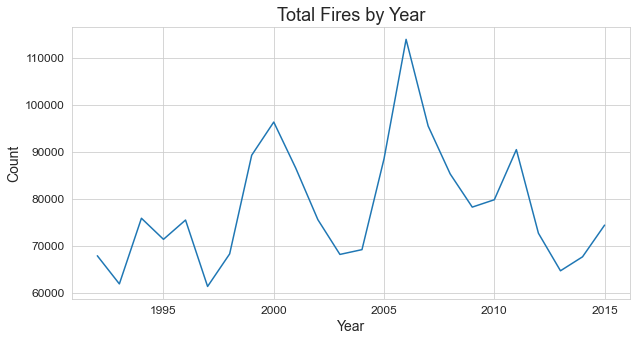

In [10]:
# Time series of causes of fire in the US

fires_by_year = df['FIRE_YEAR'].value_counts().reset_index(drop=False).sort_values('index')

plt.figure(figsize=(10,5))
sns.lineplot(data=fires_by_year, x='index', y='FIRE_YEAR')
plt.title('Total Fires by Year', size=18)
plt.xlabel('Year', size=14)
plt.xticks(size=12)
plt.ylabel('Count', size=14)
plt.yticks(size=12)
plt.show()

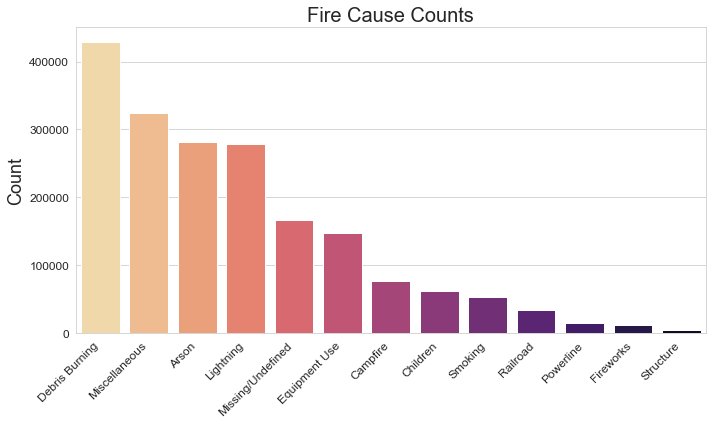

In [11]:
# Bar plot for class imbalance

cause_counts_full = pd.DataFrame(df['STAT_CAUSE_DESCR'].value_counts().reset_index(drop=False))

plt.figure(figsize=(10,6))
sns.barplot(x='index', y='STAT_CAUSE_DESCR', data=cause_counts_full, palette='magma_r')
plt.title('Fire Cause Counts', size=20)
plt.xlabel('')
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.ylabel('Count', size=18)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig./Figures/FireCausesCounts.pngpng', dpi=300)
plt.show()

### Converting dates, creating discovery month, and imputing discovery time

In [13]:
# Converting from Julian dates to Gregorian
epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['DISC_GREG_DATE'] = pd.to_datetime(df['DISCOVERY_DATE'] - epoch, unit='D')

epoch = pd.to_datetime(0, unit='s').to_julian_date()
df['CONT_GREG_DATE'] = pd.to_datetime(df['CONT_DATE'] - epoch, unit='D')

# Creating a discovery month feature
df['DISC_MONTH'] = df['DISC_GREG_DATE'].dt.month

# Imputing the missing dicovery times with the mean discovery time
disc_time_mean = pd.to_numeric(df['DISCOVERY_TIME'].dropna()).mean()
df['DISCOVERY_TIME'].fillna(disc_time_mean, inplace=True)



### Calculating the fire burn length, imputing containment date

In [14]:
# Creating a dataframe with date and size variables, dropping the NaN's
fire_dates = df[['DISCOVERY_DOY', 
                 'CONT_DOY',  
                 'FIRE_SIZE_CLASS']].copy()
fire_dates.dropna(inplace=True)

# Creating a variable for length of fire
fire_dates['Fire_length'] = fire_dates['CONT_DOY'] - fire_dates['DISCOVERY_DOY']

# Some fires that started and ended in different years are causing erroneous min/max values.
# Changing those values to NaN and then dropping them
fire_dates['Fire_length'].where((fire_dates['Fire_length'] < 300), np.NaN, inplace=True)
fire_dates['Fire_length'].where((fire_dates['Fire_length'] > 0), np.NaN, inplace=True)
fire_dates.dropna(inplace=True)


# Getting the mean `FIRE_LENGTH` by grouped `FIRE_SIZE_CLASS`
length_fireclass_mean = fire_dates.groupby('FIRE_SIZE_CLASS')['Fire_length'].mean()

# Creating a timedelta variable for each fire size class
fireclassA_length = pd.to_timedelta(length_fireclass_mean[0], unit='D')
fireclassB_length = pd.to_timedelta(length_fireclass_mean[1], unit='D')
fireclassC_length = pd.to_timedelta(length_fireclass_mean[2], unit='D')
fireclassD_length = pd.to_timedelta(length_fireclass_mean[3], unit='D')
fireclassE_length = pd.to_timedelta(length_fireclass_mean[4], unit='D')
fireclassF_length = pd.to_timedelta(length_fireclass_mean[5], unit='D')
fireclassG_length = pd.to_timedelta(length_fireclass_mean[6], unit='D')

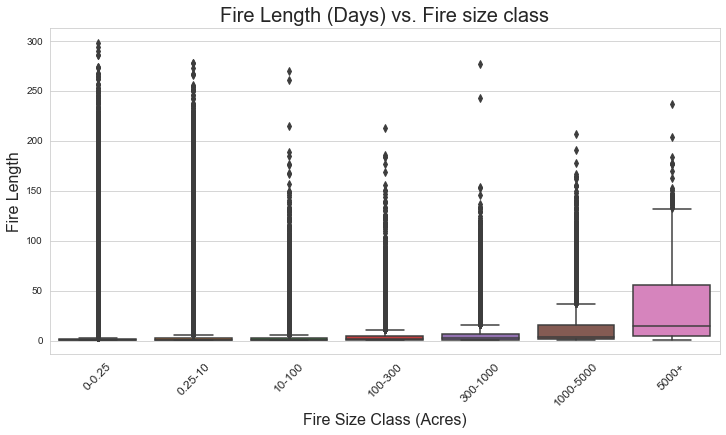

In [15]:
# Plot to show the imputation relationship between fire size and fire length
plt.figure(figsize=(12,6))
sns.boxplot(data=fire_dates, x='FIRE_SIZE_CLASS', y='Fire_length', 
            order=['A', 'B', 'C', 'D', 'E', 'F', 'G'])
plt.title('Fire Length (Days) vs. Fire size class', size=20)
plt.xlabel('Fire Size Class (Acres)', size=16)
plt.xticks([x for x in range(7)],
           ['0-0.25', '0.25-10', '10-100', '100-300', '300-1000', '1000-5000', '5000+'], 
           rotation=45, 
           size=12)
plt.ylabel('Fire Length', size=16)
plt.show()


In [16]:
def fireMeanLength(x):
    '''Function that returns a fire length for a given fire size class'''
    if x == 'A':
        return fireclassA_length
    elif x == 'B':
        return fireclassB_length
    elif x == 'C':
        return fireclassC_length
    elif x == 'D':
        return fireclassD_length
    elif x == 'E':
        return fireclassE_length
    elif x == 'F':
        return fireclassF_length
    elif x == 'G':
        return fireclassG_length

# Creating a new column in the main dataframe with the mean fire length
# by fire size group
df['FIRE_MEAN_LENGTH'] = df['FIRE_SIZE_CLASS'].apply(lambda x: fireMeanLength(x))

# Creating a column of calculated containment dates
df['Calc_CONT_DATE'] = df['DISC_GREG_DATE'] + df['FIRE_MEAN_LENGTH']

# Filling all missing data in CONT_GREG_DATE with the calculated date
df['CONT_GREG_DATE'].fillna(value=df['Calc_CONT_DATE'], inplace=True)

# Calculating the burn length of fire
df['FIRE_LENGTH'] = df['CONT_GREG_DATE'] - df['DISC_GREG_DATE']

# Changing the dtype of Fire_length to integer
df['FIRE_LENGTH'] = df['FIRE_LENGTH'].dt.days

### Dropping Missing/Undefined and Miscellaneous fire causes

In [17]:
# Dropping the Missing and Miscellaneous fire causes
df = df[~df['STAT_CAUSE_DESCR'].isin(['Miscellaneous', 'Missing/Undefined'])]

In [18]:
# List of causes to label the model confusion matrices
cause_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline',
                'Structure']

### County FIPS code engineering

In [20]:
# Dropping any fire with a missing county-level `FIPS_CODE`
df = df.dropna(subset=['FIPS_CODE'], axis=0)


# # Dictionary containing the abbreviated state name 
# # and it's associated state-level FIPS code
# state_FIPS = {
#     'AZ': '04',
#     'CA': '06',
#     'CO': '08',
#     'ID': '16',
#     'MT': '30',
#     'NV': '32',
#     'NM': '35',
#     'OR': '41',
#     'UT': '49',
#     'WA': '53',
#     'WY': '56',
# }

# # Creating a new column with the State-level FIPS code
# df['STATE_FIPS'] = df['STATE'].map(state_FIPS)

# # Prepending the state code to the county code
# df['FULL_FIPS'] = df[['STATE_FIPS', 'FIPS_CODE']].apply(''.join, axis=1)

# # Dropping the parent columns to the FULL_FIPS columns
# df.drop(columns=['FIPS_CODE', 'STATE_FIPS'], inplace=True)

### Full feature EDA

In [21]:
df.shape

(870206, 46)

In [22]:
# Getting the unique years and fire causes in the final data set
years = sorted(list(df['FIRE_YEAR'].unique()))
fire_causes = list(df['STAT_CAUSE_DESCR'].value_counts().index)

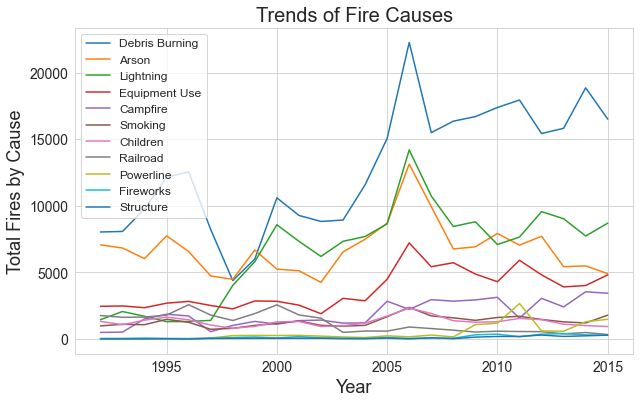

In [23]:
# Yearly time series of causes of fire in the US

# Empty DataFrame to fill iteratively
MW_fire_causes = pd.DataFrame({
    'Year': years,
    'Miscellaneous': np.zeros(24),
    'Missing/Undefined': np.zeros(24),
    'Lightning': np.zeros(24),
    'Debris Burning': np.zeros(24),
    'Arson': np.zeros(24),
    'Equipment Use': np.zeros(24),
    'Campfire': np.zeros(24),
    'Smoking': np.zeros(24),
    'Children': np.zeros(24),
    'Powerline': np.zeros(24),
    'Fireworks': np.zeros(24),
    'Railroad': np.zeros(24),
    'Structure': np.zeros(24),
})

# Iterating through years and causes, saving the number of fire causes per year to DataFrame
idx = 0
for yr in years:
    for cause in fire_causes:
        cause_value_count = df[(df['FIRE_YEAR'] == yr) & (df['STAT_CAUSE_DESCR'] == cause)].shape[0]
        MW_fire_causes.loc[idx, cause] = cause_value_count
    idx += 1

# Plotting time-series line plots for causes
plt.figure(figsize=(10,6))

for cause in fire_causes:
    sns.lineplot(data=MW_fire_causes, x='Year', y=cause)

plt.title('Trends of Fire Causes', size=20)
plt.legend(fire_causes, loc=2, fontsize=12)
plt.ylabel('Total Fires by Cause', size=18)
plt.yticks(size=14)
plt.xlabel('Year', size=18)
plt.xticks(size=14)
# plt.savefig('./Figures/FireCausesPerYear.png', dpi=300)
plt.show()

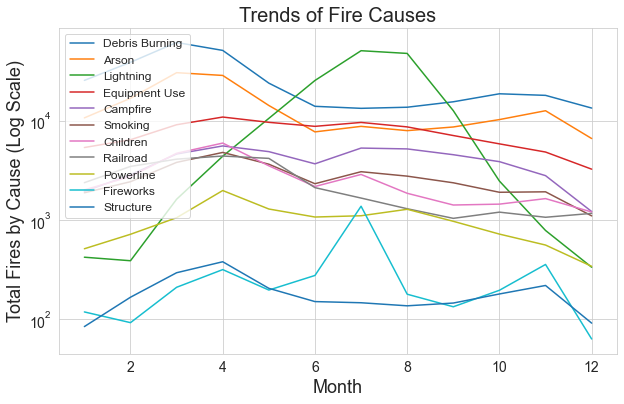

In [24]:
# Monthly time series of causes of fire in the US

months = [x for x in range(1,13)]

# Empty DataFrame to fill iteratively
MW_fire_causes_months = pd.DataFrame({
    'Month': months,
    'Miscellaneous': np.zeros(12),
    'Missing/Undefined': np.zeros(12),
    'Lightning': np.zeros(12),
    'Debris Burning': np.zeros(12),
    'Arson': np.zeros(12),
    'Equipment Use': np.zeros(12),
    'Campfire': np.zeros(12),
    'Smoking': np.zeros(12),
    'Children': np.zeros(12),
    'Powerline': np.zeros(12),
    'Fireworks': np.zeros(12),
    'Railroad': np.zeros(12),
    'Structure': np.zeros(12),
})

# Iterating through months and causes, saving the number of fire causes per year to DataFrame
idx = 0
for mn in months:
    for cause in fire_causes:
        cause_value_count = df[(df['DISC_MONTH'] == mn) & (df['STAT_CAUSE_DESCR'] == cause)].shape[0]
        MW_fire_causes_months.loc[idx, cause] = cause_value_count
    idx += 1

# Plotting time-series line plots for causes
plt.figure(figsize=(10,6))

for cause in fire_causes:
    sns.lineplot(data=MW_fire_causes_months, x='Month', y=cause)

plt.title('Trends of Fire Causes', size=20)
plt.legend(fire_causes, loc=2, fontsize=12)
plt.ylabel('Total Fires by Cause (Log Scale)', size=18)
plt.yticks(size=14)
plt.yscale('log')
plt.xlabel('Month', size=18)
plt.xticks(size=14)
# plt.savefig('./Figures/FireCausesPerYear.png', dpi=300)
plt.show()

             index  STAT_CAUSE_DESCR
0   Debris Burning            306380
1            Arson            162868
2        Lightning            156911
3    Equipment Use             89216
4         Campfire             46312
5          Smoking             31883
6         Children             31418
7         Railroad             27970
8        Powerline             11558
9        Fireworks              3500
10       Structure              2190


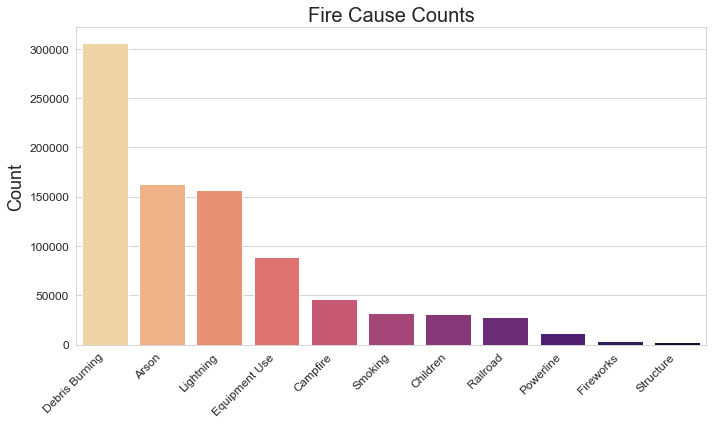

In [25]:
# Bar plot for class imbalance

cause_counts = pd.DataFrame(df['STAT_CAUSE_DESCR'].value_counts().reset_index(drop=False))
print(cause_counts)

plt.figure(figsize=(10,6))
sns.barplot(x='index', y='STAT_CAUSE_DESCR', data=cause_counts, palette='magma_r')
plt.title('Fire Cause Counts', size=20)
plt.xlabel('')
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.ylabel('Count', size=18)
plt.yticks(size=12)
plt.tight_layout()
# plt.savefig./Figures/FireCausesCounts.pngpng', dpi=300)
plt.show()

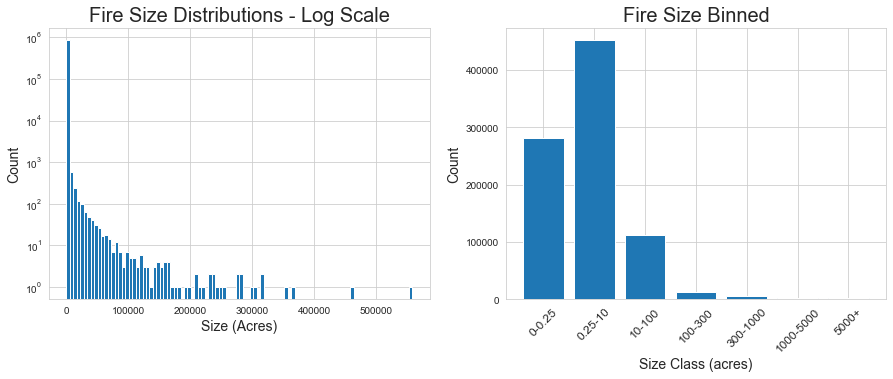

In [26]:
# Fire size distribution

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.title('Fire Size Distributions - Log Scale', size=20)
plt.hist(df['FIRE_SIZE'], bins=100, log=True)
plt.xlabel('Size (Acres)', size=14)
plt.ylabel('Count', size=14)

plt.subplot(122)
plt.title('Fire Size Binned', size=20)
plt.bar(sorted(df['FIRE_SIZE_CLASS'].unique()), 
        height=df['FIRE_SIZE_CLASS'].value_counts().sort_index())
plt.xlabel('Size Class (acres)', size=14)
plt.xticks([x for x in range(7)],
           ['0-0.25', '0.25-10', '10-100', '100-300', '300-1000', '1000-5000', '5000+'], 
           rotation=45, 
           size=12)
plt.ylabel('Count', size=14)
plt.show()

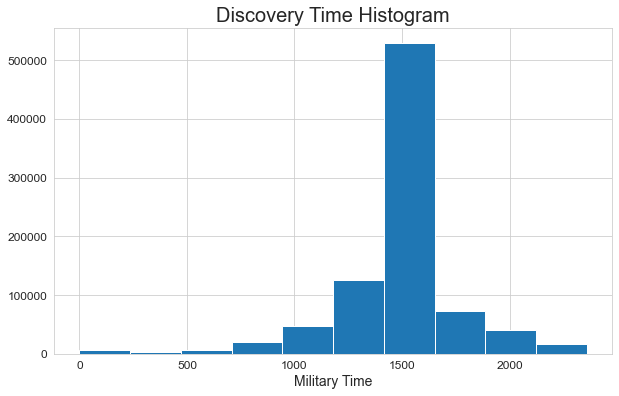

In [27]:
# Fire discovery time

plt.figure(figsize=(10,6))
plt.hist(pd.to_numeric(df['DISCOVERY_TIME']))
plt.title('Discovery Time Histogram', size=20)
plt.xlabel('Military Time', size=14)
plt.xticks(size=12)
plt.yticks(size=12)
plt.show()

## Model Prep

In [29]:
# The base DataFrame for the model

df_base = df[['STAT_CAUSE_CODE', 
              'DISC_MONTH', 
              'DISCOVERY_TIME', 
              'FIRE_LENGTH', 
              'FIRE_SIZE_CLASS', 
              'STATE',  
              'OWNER_DESCR']]

In [30]:
df_base.shape

(870206, 7)

In [31]:
df_base.head()

,STAT_CAUSE_CODE,DISC_MONTH,DISCOVERY_TIME,FIRE_LENGTH,FIRE_SIZE_CLASS,STATE,OWNER_DESCR
1,1.0,5,0845,0,A,CA,USFS
2,5.0,5,1921,0,A,CA,STATE OR PRIVATE
3,1.0,6,1600,5,A,CA,USFS
4,1.0,6,1600,5,A,CA,USFS
5,1.0,6,1800,1,A,CA,USFS


In [32]:
df_base.dtypes

STAT_CAUSE_CODE    float64
DISC_MONTH           int64
DISCOVERY_TIME      object
FIRE_LENGTH          int64
FIRE_SIZE_CLASS     object
STATE               object
OWNER_DESCR         object
dtype: object

In [34]:
# Scaling the continuous input features
df_base['DISC_MONTH'] = scale(df_base['DISC_MONTH'].copy())
df_base['DISCOVERY_TIME'] = scale(df_base['DISCOVERY_TIME'].copy())
df_base['FIRE_LENGTH'] = scale(df_base['FIRE_LENGTH'].copy())

<ipython-input-34-734c523f703d>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base['DISC_MONTH'] = scale(df_base['DISC_MONTH'].copy())
<ipython-input-34-734c523f703d>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_base['DISCOVERY_TIME'] = scale(df_base['DISCOVERY_TIME'].copy())
<ipython-input-34-734c523f703d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

In [35]:
print(df_base.head())

print(df_base.columns[[1,4]])

   STAT_CAUSE_CODE  DISC_MONTH  DISCOVERY_TIME  FIRE_LENGTH FIRE_SIZE_CLASS  \
1              1.0   -0.254103       -2.166824    -0.231905               A   
2              5.0   -0.254103        1.644373    -0.231905               A   
3              1.0    0.077885        0.507390     0.210933               A   
4              1.0    0.077885        0.507390     0.210933               A   
5              1.0    0.077885        1.215791    -0.143337               A   

  STATE       OWNER_DESCR  
1    CA              USFS  
2    CA  STATE OR PRIVATE  
3    CA              USFS  
4    CA              USFS  
5    CA              USFS  
Index(['DISC_MONTH', 'FIRE_SIZE_CLASS'], dtype='object')


In [36]:
def onehot(df, cols):
    '''One hot encode the categoricals, then drop the original columns'''
    for c in cols:
        dummies = pd.get_dummies(df[c], prefix=c, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df.drop(columns=c, inplace=True)
    return df

# Selecting the categorical features and OHE them
onehotcolumns = df_base.columns[-3:]
df_ohe_final = onehot(df_base, onehotcolumns)

In [37]:
df_ohe_final.shape

(870206, 77)

In [39]:
# Creating the target and input features
Y_ohe = df_ohe_final['STAT_CAUSE_CODE']
X_ohe = df_ohe_final.iloc[:, 1:].copy()

In [41]:
# Splitting the data, using stratify because of the class imbalance and 
# random state because we will need to do this split for linear models and tree-based models
X_train, X_test, Y_train, Y_test = train_test_split(X_ohe, 
                                                    Y_ohe, 
                                                    stratify=Y_ohe, 
                                                    random_state=93692)


In [42]:
print('Split data shapes')
print('X_train', X_train.shape)
print('X_test', X_test.shape)

Split data shapes
X_train (652654, 76)
X_test (217552, 76)


In [43]:
print('Split data fire cause counts')
print('Y_train')
print(Y_train.value_counts(), '\n')
print('Y_test')
print(Y_test.value_counts())

Split data fire cause counts
Y_train
5.0     229785
7.0     122151
1.0     117683
2.0      66912
4.0      34734
3.0      23912
8.0      23563
6.0      20977
11.0      8669
10.0      2625
12.0      1643
Name: STAT_CAUSE_CODE, dtype: int64 

Y_test
5.0     76595
7.0     40717
1.0     39228
2.0     22304
4.0     11578
3.0      7971
8.0      7855
6.0      6993
11.0     2889
10.0      875
12.0      547
Name: STAT_CAUSE_CODE, dtype: int64


### Logistic Regression Models

In [44]:
# Best ridge logistic regression model from the grid search
ridge = LogisticRegression(solver='lbfgs', 
                           penalty='l2', 
                           multi_class='multinomial', 
                           C=.9, 
                           max_iter=500, 
                           n_jobs=3)
ridge.fit(X_train, Y_train)
Y_pred_ridge = ridge.predict(X_test)

# Calculating model metrics
BalAccTst = balanced_accuracy_score(Y_test, Y_pred_ridge)
WF1Tst = f1_score(Y_test, Y_pred_ridge, average='weighted')
# class_report = classification_report(Y_test, Y_pred, labels=cause_labels)  # Error due to some classes not predicted

print('Balanced Accuracy :', BalAccTst)
print('Weighted F1 :', WF1Tst)
# print(class_report)

# Total number of predictions per class from the ridge model.
ridge_results = pd.DataFrame(Y_pred_ridge)[0].value_counts()
print(ridge_results)

Balanced Accuracy : 0.21959034187872628
Weighted F1 : 0.44923684612177145
5.0     121402
1.0      48689
7.0      32357
6.0       8685
2.0       5355
4.0       1043
11.0        14
3.0          4
10.0         2
8.0          1
Name: 0, dtype: int64


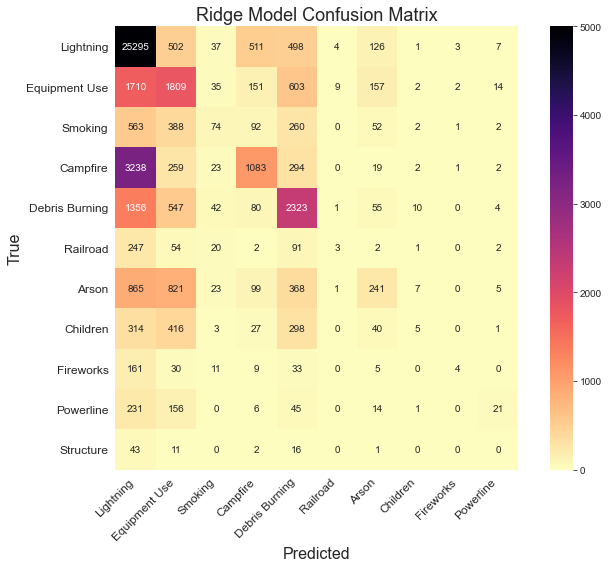

In [56]:
# Ridge confusion matrix
ridge_cfmx = pd.crosstab(Y_test, Y_pred_ridge)

ridge_labels = ['Lightning',
                'Equipment Use',
                'Smoking',
                'Campfire',
                'Debris Burning',
                'Railroad',
                'Arson',
                'Children',
                'Fireworks',
                'Powerline']

plt.figure(figsize=(10,8))
sns.heatmap(ridge_cfmx, 
            xticklabels = ridge_labels, 
            yticklabels = cause_labels,
            annot = True,
            fmt = 'g',
            square = True, 
            vmax = 5000,
            vmin = 0,
            cmap = 'magma_r')
plt.title('Ridge Model Confusion Matrix', size=18)
plt.ylabel('True', size=16)
plt.yticks(size=12)
plt.xlabel('Predicted', size=16)
plt.xticks(rotation=45, size=12, horizontalalignment='right')
plt.tight_layout()
#plt.savefig('./Figures/Ridge_lbfgs_c0.9_cfmx.png', dpi=300, transparent=True)
plt.show()

### Logistic Regression - Approach 2

In [64]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(max_iter=500)

In [65]:
from sklearn.model_selection import train_test_split

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X_ohe,Y_ohe, test_size=0.3)